## Project

The last part of this assignment is an open-ended project. Choose a sociologically interesting question about either the CAVIAR network or the facebook or twitter network from the recitation notebook section (for the social network data, go to https://snap.stanford.edu/data/ego-Facebook.html and https://snap.stanford.edu/data/ego-Twitter.html, or any other publicly available network data set, e.g. those at https://snap.stanford.edu/data/index.html.

Try to answer your own question using the data. You can subset the data in whichever way you desire as long as it is (sociologically) meaningful. For example, in the case of a cooffending network, you could group nodes by attributes such as sex, group edges such as repeat/non-repeating cooffenses, use the weighted or unweighted co-offending networks, focus on the largest connected component, etc. Think of how you may want to subset the data in the context of the CAVIAR or the social networks, or the publicly available network data set you have chosen.

### Project expectations/Rubric:

Clearly states a sociological question which is interesting and relevant to the data. The question must be sociologically motivated: for example, “Compare the network structure in 2003 vs 2009" is not a good question, without further context. If you have some reason to believe that the network structure changes in those years, then you should make that your central question: for example, “Did crimes involving youth offenders become more organized and structured over the years" is a better question, from which comparing the structure in different years becomes part of the methodology to answer the question. More examples of possible questions for cooffending networks are provided below.


Points Awarded | Requirement Description
---------|----------
2 points | Describes methodology for network analysis.
2 points | Grader is convinced that the methodology makes sense for the question to be answered. Grader is convinced that no additional methodology within the bounds of techniques taught and discussed in this module could be applied beyond what was described. The grader should only consider additional methodology that adds meaningfully to the answer for the question: additions that simply repeat or confirm the presented results should not be considered by the grader. If a justification is provided for why a particular method was not used, the grader should be convinced by that argument.
2 points | Presents results, including figures and/or statistics, which address the question of interest.
2 points | The described methodology has been applied in complete and the results shown (that is, the author did not forget to include anything they discussed in the methodology.)
0 points | Adequately discusses the results obtained.
2 points | Question does not need to be successfully answered, but the grader should be convinced that the author has answered the question to the best ability of the methodology presented.
1 point | Provides commentary on what was discovered, what were the limitations of the methods, what may have been surprising to discover, etc.
1 point | Award this point if the question was successfully answered to the grader's satisfaction.  

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import pprint
import matplotlib.pyplot as plt
from typing import List, Union, Dict, Tuple
import snap

# Instantiate a pretty printer
pp = pprint.PrettyPrinter(indent=4)

### Loading Dataset

In [2]:
phases = {}
G = {}

# Load the data from the internet
for idx in range(1,12): 

    # Build the file name
    var_name = "phase" + str(idx)
    file_name = "https://raw.githubusercontent.com/ragini30/Networks-Homework/main/" + var_name + ".csv"

    # Load and properly parse the data
    phases[idx] = pd.read_csv(file_name, index_col = ["players"])
    phases[idx].columns = "n" + phases[idx].columns
    phases[idx].index = phases[idx].columns
    phases[idx][phases[idx] > 0] = 1

    # Turn the generated pandas dataframe into a networkx graph
    G[idx] = nx.from_pandas_adjacency(phases[idx], create_using=nx.DiGraph)
    G[idx].name = var_name

### Project Proposal

#### Question

Was the reaction from "high rank" members of the organization to the police operations different than the reaction from "low rank" members?

#### Methodology

In order to analyze if the reaction from high rank members was different than the reaction from low rank members, we will use the centrality metrics we learned in class. We will use the following metrics:

1. Take the dataset an use different centrality metrics to get the most relevant nodes from the network.
2. Get the average of the metrics among the most relevant nodes and compare them against the behavior of the "least relevant" nodes.
3. Analyze the evolution of the "important" versus the "less important" nodes over time. Check if the evolution changes depending on the different police interventions. Also analyze if the effects were amplified in the cases when a higher number of seizures were made.
4. Use the previously taught clustering techniques to generate new groupings of nodes. 
5. Check if the new groupings display more or less information flow than the naive grouping used before. 

#### Step 1: Centrality Metrics

In [6]:
from typing import Dict, Callable, Any, List, Tuple

def average_centrality(
    G: Dict[int, nx.Graph], 
    metric_func: Callable[..., Any],
    reverse=True,
    num_players: int = 110

) -> List[Tuple[str, float]]:
    """
    Calculate the average value of any centrality measure, by averaging the 
    centrality measure for each node across all phases. The returned dictionary
    is sorted in descending order by the average centrality measure.

    Parameters
    ----------
    G : nx.Graph
        Graph that contains the time-varying data to average over.

    metric_func : Callable[..., Any]
        Function that calculates the centrality measure. 
    
    reverse : bool
        Whether or not to "reverse" the graph. Useful to calculate things like the
        right eigenvector centrality, which is the same as the left eigenvector
        centrality but for the reversed graph.

    num_players : int
        Number of distinct nodes in the graph. Since the CAVIAR dataset is being
        used, by default this is set to 110.
    """

    # List of the phase numbers
    phases = list(range(1,12))

    # Apply the "reverse" of the graph if the user requests it
    if reverse:
        G = {i: G[i].reverse() for i in phases}

    # Get the centrality for each node in each phase
    measure_centrality = {
        i: metric_func(G[i]) for i in phases
    }

    # Average degree centrality for each node across all phases
    average_measure = {}
    for i in range(num_players):

        # Get the node name
        node_name = "n" + str(i + 1)

        # Initialize the average degree centrality
        average_measure[node_name] = 0

        for phase in phases:
            if node_name not in measure_centrality[phase]:
                average_measure[node_name] += 0
            else:
                average_measure[node_name] += measure_centrality[phase][node_name]
        
        # Divide by the number of phases
        average_measure[node_name] /= len(phases)

    # Sort the average degree centrality
    sorted_average = sorted(
        average_measure.items(), 
        key=lambda x: x[1], 
        reverse=True
    )
    return sorted_average 

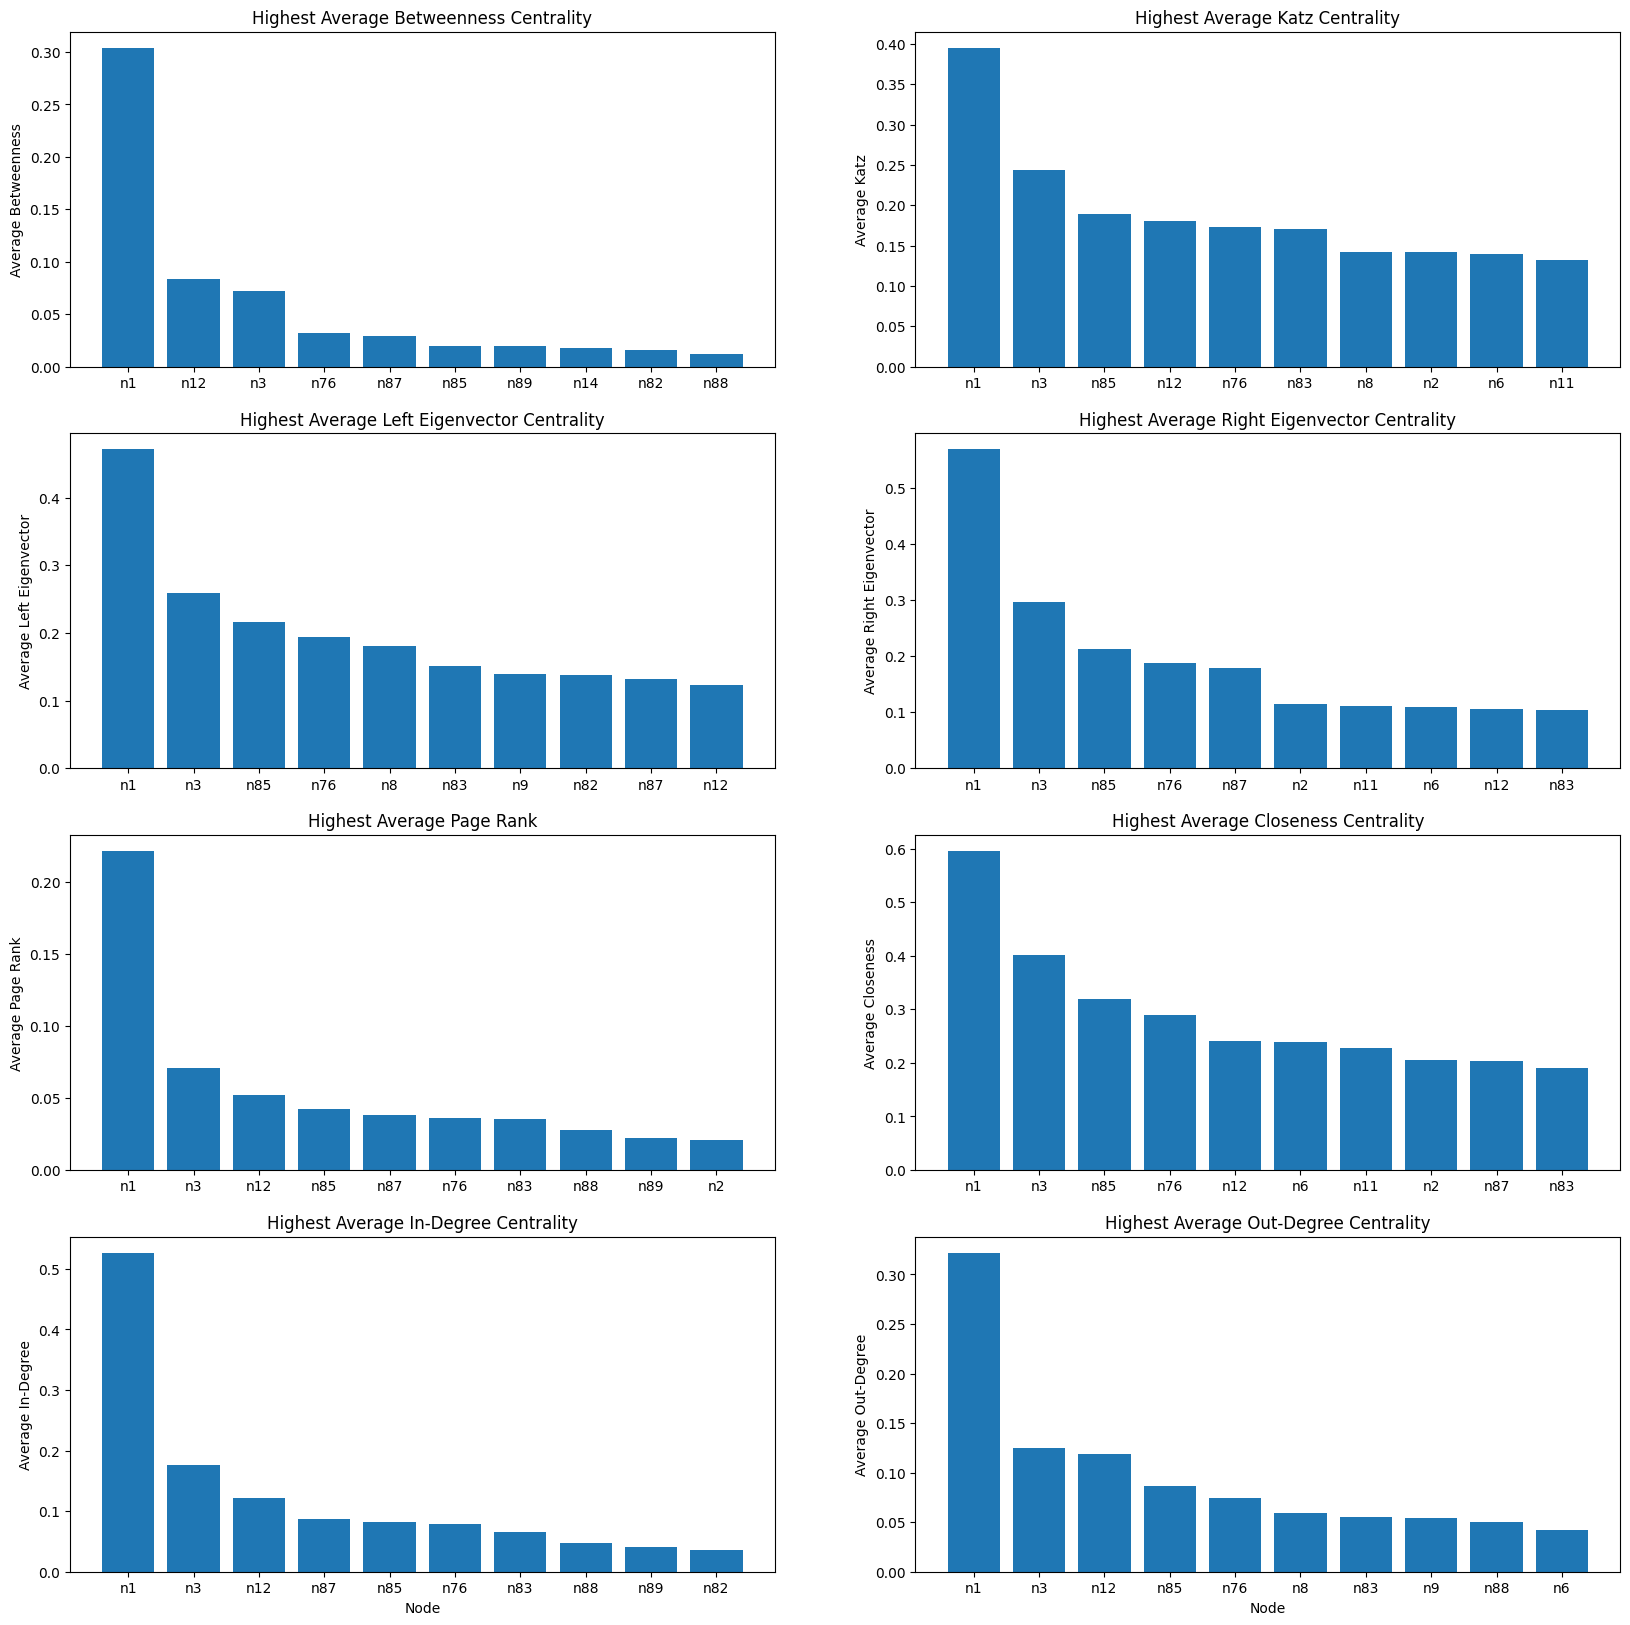

In [11]:
# List of average centrality measures
average_centrality_measures = {
    "Betweenness": average_centrality(G, nx.betweenness_centrality),
    "Katz": average_centrality(G, nx.katz_centrality),
    "Left Eigenvector": average_centrality(G, nx.eigenvector_centrality, reverse=False),
    "Right Eigenvector": average_centrality(G, nx.eigenvector_centrality, reverse=True),
    "Page Rank": average_centrality(G, nx.pagerank),
    "Closeness": average_centrality(G, nx.closeness_centrality),
    "In-Degree": average_centrality(G, nx.in_degree_centrality),
    "Out-Degree": average_centrality(G, nx.out_degree_centrality),
}

# Get the number of rows for the figure. This will consist of the number of
# centrality measures divided by 2, rounded up
num_rows = int(np.ceil(len(average_centrality_measures) / 2))

# Generate a figure with 2 columns and as mny rows as necessary
fig, axes = plt.subplots(num_rows, 2, figsize=(20, 5*num_rows))

# Transform the tuple of tuples into a single list of axes
axes = [item for sublist in axes for item in sublist]

# Plot each of the average centrality measures
for idx, (measure, average) in enumerate(average_centrality_measures.items()):

    # Get the top 10 nodes with the highest average centrality
    sorted_average_keys = [
        node[0] for node in average[:10]
    ]
    sorted_average_values = [
        node[1] for node in average[:10]
    ]

    # Generate a bar plot for the average centrality measure
    axes[idx].bar(
        x=sorted_average_keys,
        height=sorted_average_values,
    )

    # Set the title of the plot, not including the word "Centrality" if the
    # measure is not a centrality measure
    if measure in ["Page Rank"]:
        axes[idx].set_title(f"Highest Average {measure}")
    else:
        axes[idx].set_title(f"Highest Average {measure} Centrality")
    
    # Set the y-label
    axes[idx].set_ylabel(f"Average {measure}")

    # If the last row is being plotted, set the x-label
    if idx >= len(average_centrality_measures) - 2:
        axes[idx].set_xlabel("Node")


plt.show()

From a glimpse of the data, it is clear that regardless of the centrality metric chosen, the set of nodes with the highest metric values will remain mostly the same:

- n1 and n3: These appear in the first two places in all centrality metrics, except for betweenness centrality, where they occupy the 1sd and 3rd places, respectively. This makes sense as the nodes correspond to the mastermind of the operation (n1: Daniel Serero) and his right hand (n3: Pierre Perlini). An increase in average value is to be expected as they are better connected, receive and send the most information and because of all of the previous, they are considered one of the most important nodes in the network.
- n12: Ernesto Morales, the principal organizer of the cocaine import. He displays a very high in and out-degree, page rank and betweenness.
- n85: Wallace Lee, the accountant. Characterized by relatively high in and out-degree, left and right eigenvector centrality and Katz centrality.
- n87: Patrick Lee, an investor. He has a high in-degree and a relatively high page rank and betweenness.
- n76: Gabrielle Casale, marijuana recuperator. Her metrics are slightly lower that the previous node, placing generally in places 4-7, with a higher in and out degree, closeness, left/right eigenvector, betweenness and Katz centrality.
- n83: Alain Levy, money transporter. Relatively high in in and out degree, left eigenvector centrality and Katz centrality.
- n2: Not in the list of suspects. Has a relatively high closeness, page rank, slightly higher right eigenvector centrality and katz centrality.
- n11: Samir Rabbat, provider in Morocco. High closeness, right eigenvector centrality and Katz centrality.

These are some of the most important nodes fetched by inspection. Now we will get them programmatically, in a more quantitative way. This is done by getting the "n" nodes with the highest values for each of the centrality metrics, and then getting the nodes that get repeated the most.

In [40]:
from collections import Counter

# How many "important" and "non-important" players we want to compare
num_nodes = 10

# =========== MOST IMPORTANT PLAYERS =========== #

# Get the nodes with the highest scores for each centrality measure
highest_nodes = {
    measure: [
        node[0] for node in average[:10]
    ] for measure, average in average_centrality_measures.items()
}

# Join all the lists of nodes into a single list
all_highest_nodes = [
    node for nodes in highest_nodes.values() for node in nodes
]

# Get the "num_nodes" most common nodes from "all_highest_nodes"
highest_node_counts = Counter(all_highest_nodes).most_common(num_nodes)
important_players = [node[0] for node in highest_node_counts]
print("Important Players:", important_players)

# =========== LEAST IMPORTANT PLAYERS ========== #

# Get the nodes with the lowest scores for each centrality measure
lowest_nodes = {
    measure: [
        node[0] for node in average[-10:]
    ] for measure, average in average_centrality_measures.items()
}

# Join all the lists of nodes into a single list
all_lowest_nodes = [
    node for nodes in lowest_nodes.values() for node in nodes
]

# Get the "num_nodes" most common nodes from "all_lowest_nodes"
lowest_node_counts = Counter(all_lowest_nodes).most_common(num_nodes)
non_important_players = [node[0] for node in lowest_node_counts]
print("Non-important Players:", non_important_players)

Important Players: ['n1', 'n12', 'n3', 'n76', 'n85', 'n83', 'n87', 'n88', 'n2', 'n6']
Non-important Players: ['n110', 'n103', 'n95', 'n57', 'n60', 'n106', 'n109', 'n104', 'n105', 'n91']


Now that an adequate subset of the most important nodes has been identified, we can take the same number of non-important nodes, and then we can average their statistics to compare the evolution of an "average important node" against the evolution of an "average non-important node".

In [36]:
# Dictionary listing the different centrality measures
centrality_measures = {
    "Betweenness": nx.betweenness_centrality,
    "Katz": nx.katz_centrality,
    "Left Eigenvector": lambda G: nx.eigenvector_centrality(G),
    "Right Eigenvector": lambda G: nx.eigenvector_centrality(G.reverse()),
    "Page Rank": nx.pagerank,
    "Closeness": nx.closeness_centrality,
    "In-Degree": nx.in_degree_centrality,
    "Out-Degree": nx.out_degree_centrality,
}

# Function to extract the measure history for a set of nodes
def get_measure_history(G, nodes):

    # Get the measure history for each measure and each "important player"
    measure_history = {}
    for measure in centrality_measures:

        measure_history[measure] = {}
        for node in nodes:

            # Initialize the measure history for each player
            measure_history[measure][node] = []

            # Measure values for each node are stored as a list for each phase
            for phase in range(1, 12):

                # Check if the node exists in the current phase
                if node in G[phase]:
                    measure_history[measure][node].append(
                        centrality_measures[measure](G[phase])[node]
                    )
                else:
                    measure_history[measure][node].append(0)

    return measure_history

# =============== MEASURE HISTORY ============== #

# Important nodes measure history
important_nodes_history = get_measure_history(G, important_players)

# Non-important nodes measure history
non_important_nodes_history = get_measure_history(G, non_important_players)

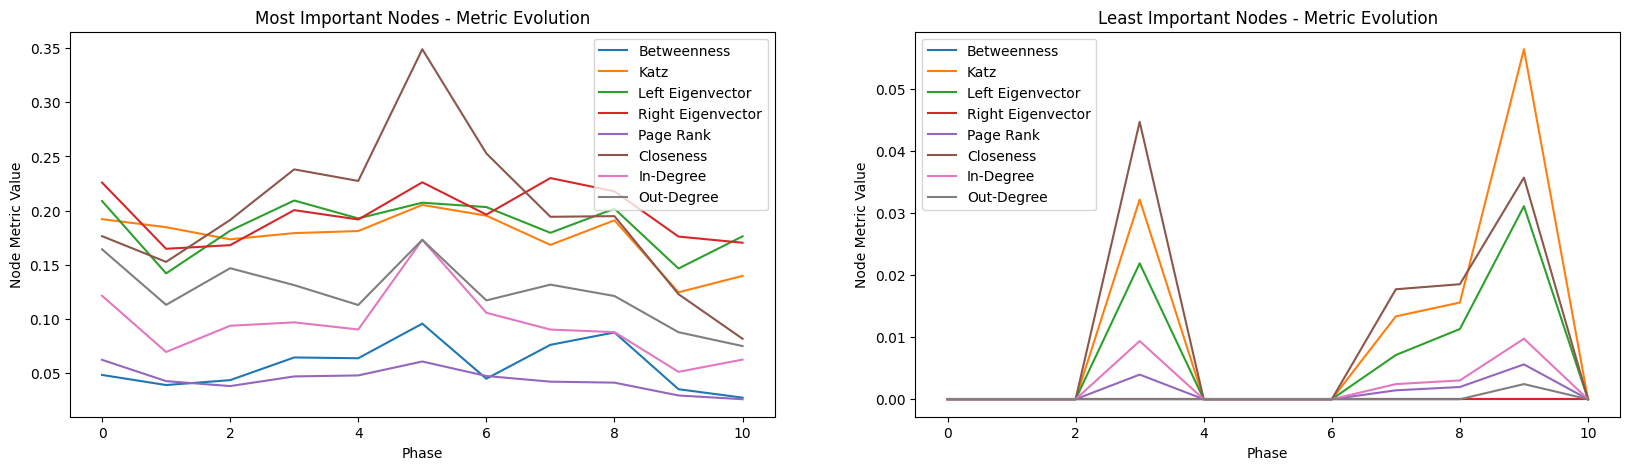

In [42]:
# Average the measurements of the non-important players
non_important_nodes_average = {
    measure: [
        np.mean([
            non_important_nodes_history[measure][node][phase] for node in non_important_players
        ]) for phase in range(11)
    ] for measure in centrality_measures
}

# Average the measurements of the important players
important_nodes_average = {
    measure: [
        np.mean([
            important_nodes_history[measure][node][phase] for node in important_players
        ]) for phase in range(11)
    ] for measure in centrality_measures
}

# Generate a figure with 2 columns and 1 row
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# In the first plot add 1 line for each of the measures 
for measure in centrality_measures:
    axes[0].plot(
        important_nodes_average[measure],
        label=measure
    )
    axes[1].plot(
        non_important_nodes_average[measure],
        label=measure
    )

# Set the titles
axes[0].set_title("Most Important Nodes - Metric Evolution")
axes[1].set_title("Least Important Nodes - Metric Evolution")

# Set the x-label
axes[0].set_xlabel("Phase")
axes[1].set_xlabel("Phase")
axes[0].set_ylabel("Node Metric Value")
axes[1].set_ylabel("Node Metric Value")

# Show the legend
axes[0].legend()
axes[1].legend()

plt.show()
